## `Step 1` : Load libraries & Datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader
from torch import nn


from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.transforms.functional import to_pil_image

In [3]:
# Datasets
train_img = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform = transforms.ToTensor(),
)

test_img = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

100%|████████████████████████████████████████████████████████████████| 170498071/170498071 [00:18<00:00, 9081435.00it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## `Step 2` : Data preprocessing
불러온 이미지의 증강을 통해 학습 정확도를 향상시키도록 합니다. 

`-` RandomCrop  
`-` RandomHorizontalFlip  
`-` Normalize 

In [4]:
mean = train_img.data.mean(axis=(0,1,2)) / 255
std = train_img.data.std(axis=(0,1,2)) / 255
print(f'평균: {mean}, 표준편차:{std}')

평균: [0.49139968 0.48215841 0.44653091], 표준편차:[0.24703223 0.24348513 0.26158784]


In [5]:
train_img.data.shape , test_img.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomCrop(size=train_img.data.shape[1], padding=4),
    transforms.RandomHorizontalFlip(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [7]:
train_img2  = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform = transform_train,
)

test_img2 = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = transform_test,
)

Files already downloaded and verified
Files already downloaded and verified


## `Step 3` : Set hyperparameters

In [8]:
epochs = 10
batch_sizes = 128
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

Using Device: cuda


## `Step 4` : Create DataLoader

In [9]:
# Create DataLoader
train_loader = DataLoader(train_img2, batch_size = batch_sizes, shuffle = True)
test_loader = DataLoader(test_img2, batch_size = batch_sizes, shuffle = True)

## EDA

In [10]:
print(train_img, '\n-----------------------\n', test_img)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() 
-----------------------
 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [11]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


In [12]:
labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

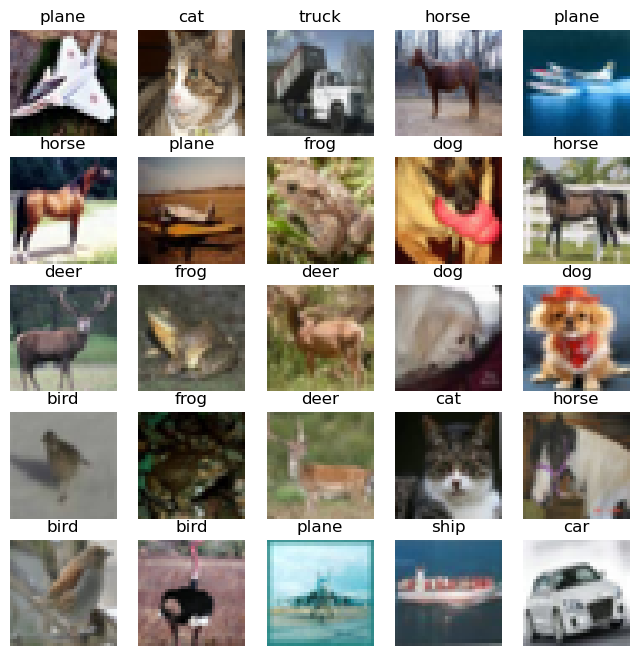

In [13]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5

for i in range(1, cols * rows +1):
    sample_idx = torch.randint(len(train_img), size=(1,)).item()
    img, label = train_img[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(to_pil_image(img))
plt.show()

## `Step 5` : Set Network Structure

In [14]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 4096),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return(x)

## `Step 6` : Create Model instance

In [15]:
# Create Moedl instance
model = AlexNet().to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=4096, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=4096, out_fea

## `Step 7` : Model compile

In [16]:
# loss
loss = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## `Step 8` : Set train loop

In [17]:
def train(train_loader, model, loss_fn, optimizer):
    model.train()

    size = len(train_loader.dataset)

    for batch, (X,y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        pred = model(X)

        # loss calculation
        loss = loss_fn(pred, y)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}]/{size:5d}')

## `Step 9` : Set test loop

In [18]:
def test(test_loader, model, loss_fn):
    model.eval()

    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss:  {test_loss:8f}\n")

## `Step 10` : Run Model

In [19]:
for i in range(epochs):
    print(f"epochs {i+1} \n-----------------------------")
    train(train_loader, model, loss, optimizer)
    test(test_loader, model, loss)
print('Done!')

epochs 1 
-----------------------------


/root/anaconda3/envs/py/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


loss: 2.300106  [    0]/50000
loss: 1.961412  [12800]/50000
loss: 1.877241  [25600]/50000
loss: 1.800212  [38400]/50000
Test Error: 
 Accuracy: 31.4%, Avg loss:  1.762373

epochs 2 
-----------------------------
loss: 1.795186  [    0]/50000
loss: 1.576234  [12800]/50000
loss: 1.639605  [25600]/50000
loss: 1.649888  [38400]/50000
Test Error: 
 Accuracy: 44.0%, Avg loss:  1.494407

epochs 3 
-----------------------------
loss: 1.534194  [    0]/50000
loss: 1.496532  [12800]/50000
loss: 1.524187  [25600]/50000
loss: 1.440067  [38400]/50000
Test Error: 
 Accuracy: 49.1%, Avg loss:  1.400005

epochs 4 
-----------------------------
loss: 1.554884  [    0]/50000
loss: 1.389567  [12800]/50000
loss: 1.310677  [25600]/50000
loss: 1.434475  [38400]/50000
Test Error: 
 Accuracy: 51.9%, Avg loss:  1.308864

epochs 5 
-----------------------------
loss: 1.384561  [    0]/50000
loss: 1.448307  [12800]/50000
loss: 1.549824  [25600]/50000
loss: 1.296622  [38400]/50000
Test Error: 
 Accuracy: 54.0%, A

## **`Step 11` : Confusion Matrix**

In [53]:
import itertools
def plot_confusion_matrix(cm, target_names=None, cmap=None, 
                          normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f};\
                         misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [55]:
from sklearn.metrics import confusion_matrix

model.eval()
ylabel = []
ypred_label = []

for batch_idx, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predicted = outputs.max(1)
    ylabel = np.concatenate((ylabel, targets.cpu().numpy()))
    ypred_label = np.concatenate((ypred_label, predicted.cpu().numpy()))

cnf_matrix = confusion_matrix(ylabel, ypred_label)

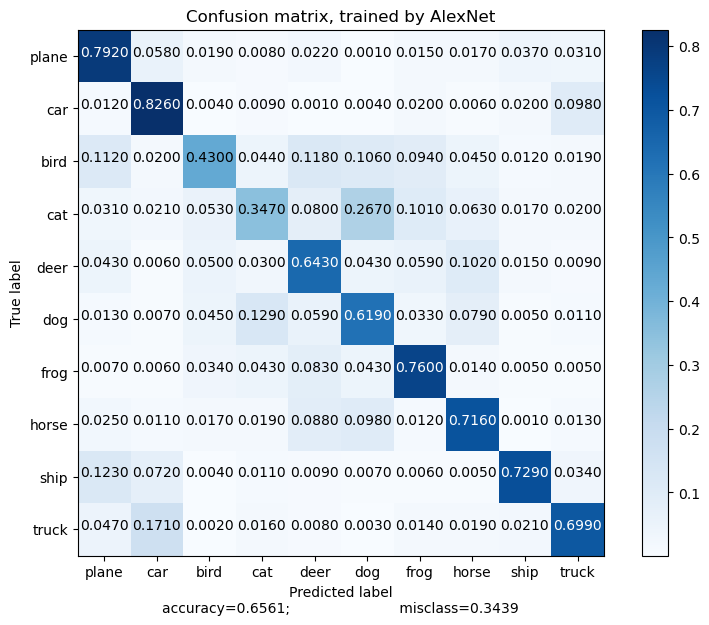

In [56]:
plot_confusion_matrix(cnf_matrix, 
                      target_names=labels_map.values(), 
                      title='Confusion matrix, trained by AlexNet')